# Buisness cycles and unemployment 

In this project we want to explore how buisness cycles and unemployment are correlated and if this varries across age groups. We explore this by using data for the danish GDP and danish unemployment for different age groups. Our hypothesis is that unemployment is highest for the youngest age group, as we asume are larger share "suffers" from post study unemployment and more people choose to be unemployed. Further more we also think this group's unemployment is more volitile, as many younger people work in jobs that are affected quicker by how the economy is going. 

# 

Imports:

In [82]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns


# Read and clean data

We load data from "statistikbanken" for unemployment and BNP but it loads more varibles than we need so we inspect the loaded data. We only want unemployment for both genders total in the whole period (2008-2023). We only want BNP for fixed prices and only in perioed 2007-2023 

In [59]:
AKU = DstApi('AKU111A') 
BNP = DstApi('NAN1') 

In [60]:
tabsum_AKU= AKU.tablesummary(language='en')
display(tabsum_AKU)
tabsum_BNP= BNP.tablesummary(language='en')
display(tabsum_BNP)


Table AKU111A: Labour force status in percentage by employment status, age, sex and time
Last update: 2024-02-22T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BESKSTATUS,3,BFK,Employment rate,EFK,Economic activity rate,False
1,ALDER,7,TOT,"Age, total",6574,65-74 years,False
2,KØN,3,TOT,Total,K,Women,False
3,Tid,16,2008,2008,2023,2023,True


Table NAN1: Demand and supply by transaction, price unit and time
Last update: 2024-03-27T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,31,B1GQK,B.1*g Gross domestic product,EMPM_DC,"Total employment (1,000 persons)",False
1,PRISENHED,6,V_M,"Current prices, (bill. DKK.)",LAN_C,"Pr. capita, 2010-prices, chained values, (1000...",False
2,Tid,58,1966,1966,2023,2023,True


We further explore the varibels contained in the data set so we know what ID the varibales we are intrested in has. We see for AKU that unemployment rate has id LPCT in the category BESKSTATUS, Total has id TOT in the category KØN. For BNP we see that BNP has the ID B1GQK in category TRANSAKT, fixed prices has the ID LAN_M in category PRISENHED, and the years has the ID that is just the name of the year in the category tid. To make the code easier to read we have denoted all the explorative lines of codes. If you want to see our process just remove all '''

In [61]:
'''
for var in tabsum_AKU['variable name']:
    print(var+':')
    display(AKU.variable_levels(var, language='en'))
'''

"\nfor var in tabsum_AKU['variable name']:\n    print(var+':')\n    display(AKU.variable_levels(var, language='en'))\n"

In [62]:
'''
for var in tabsum_BNP['variable name']:
    print(var+':')
    display(BNP.variable_levels(var, language='en'))
'''

"\nfor var in tabsum_BNP['variable name']:\n    print(var+':')\n    display(BNP.variable_levels(var, language='en'))\n"

As we have now identified the variables we want to use for unemplyment, we start selecting the relevant varibles.

In [63]:
params_AKU= AKU.define_base_params(language='en')
params_AKU

{'table': 'aku111a',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'BESKSTATUS', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KØN', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [64]:
params_AKU={'table': 'aku111a',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'BESKSTATUS', 'values': ['LPCT']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KØN', 'values': ['TOT']},
  {'code': 'Tid', 'values': ['*']}]}




In [65]:
AKU_api=AKU.get_data(params=params_AKU)

AKU_api.sort_values(by=['TID','ALDER'], inplace=True)
AKU_api.head(10)

,BESKSTATUS,ALDER,KØN,TID,INDHOLD
57,ILO-unemployment rate,15-24 years,Total,2008,9.5
28,ILO-unemployment rate,25-34 years,Total,2008,3.7
0,ILO-unemployment rate,35-44 years,Total,2008,2.6
86,ILO-unemployment rate,45-54 years,Total,2008,2.0
58,ILO-unemployment rate,55-64 years,Total,2008,2.5
29,ILO-unemployment rate,65-74 years,Total,2008,..
85,ILO-unemployment rate,"Age, total",Total,2008,3.7
30,ILO-unemployment rate,15-24 years,Total,2009,13.4
1,ILO-unemployment rate,25-34 years,Total,2009,7.2
87,ILO-unemployment rate,35-44 years,Total,2009,4.7


Here we finish manipulating our datasubset so it only contains the variables we need. The final variables for our unemployment data can be seen here:

In [66]:
AKU_Data = AKU_api.copy()

AKU_Data.rename(columns = {'INDHOLD':'UNR'},inplace=True)
del AKU_Data['BESKSTATUS']
del AKU_Data['KØN']
AKU_Data.head(100)

,ALDER,TID,UNR
57,15-24 years,2008,9.5
28,25-34 years,2008,3.7
0,35-44 years,2008,2.6
86,45-54 years,2008,2.0
58,55-64 years,2008,2.5
...,...,...,...
108,55-64 years,2021,4.1
80,65-74 years,2021,3.3
23,"Age, total",2021,5.1
81,15-24 years,2022,10.5


We now do the same for our data for GDP, by creating a subset which only contains the variables we need. 

In [67]:
params_BNP= BNP.define_base_params(language='en')
params_BNP

{'table': 'nan1',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TRANSAKT', 'values': ['*']},
  {'code': 'PRISENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [68]:
params_BNP = {'table': 'nan1',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TRANSAKT', 'values': ['B1GQK']},
  {'code': 'PRISENHED', 'values': ['LAN_M']},
  {'code': 'Tid', 'values': ['>2006<=2023']}]}

In [69]:
BNP_api=BNP.get_data(params=params_BNP)
BNP_api.sort_values(by=['TID'], inplace=True)
BNP_api.head(4)

,TRANSAKT,PRISENHED,TID,INDHOLD
0,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",2007,1879.0
1,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",2008,1869.4
2,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",2009,1777.7
3,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",2010,1810.9


In [70]:
BNP_Data = BNP_api.copy()

BNP_Data.rename(columns = {'INDHOLD':'GDP_str'},inplace=True)
del BNP_Data['TRANSAKT']
del BNP_Data['PRISENHED']

BNP_Data['GDP'] = BNP_Data['GDP_str'].astype(float)

BNP_Data['Growth_Rate'] = (BNP_Data['GDP']-BNP_Data['GDP'].shift(1))/BNP_Data['GDP'].shift(1)*100

del BNP_Data['GDP_str']

BNP_Data.head(4)

,TID,GDP,Growth_Rate
0,2007,1879.0,NaN
1,2008,1869.4,-0.510910
2,2009,1777.7,-4.905317
3,2010,1810.9,1.867582


We now have deleted all irrelevant varibles and calculated the growth rate in gdp. This is our final subset for our GDP data:

In [71]:
BNP_Data.head(4)

,TID,GDP,Growth_Rate
0,2007,1879.0,NaN
1,2008,1869.4,-0.510910
2,2009,1777.7,-4.905317
3,2010,1810.9,1.867582


Before we explore the correlation between buisness cycles and unemployment we first look at buisness cycles, to see if they are present in the dataset which we see they are. We do this by first defining a boom and decline threshold which we for simplicity set to 2 and 0 percent. We then display our data for GDP growth rate and mark all periods above the boom threshold with green and below the decline threshold with red. 

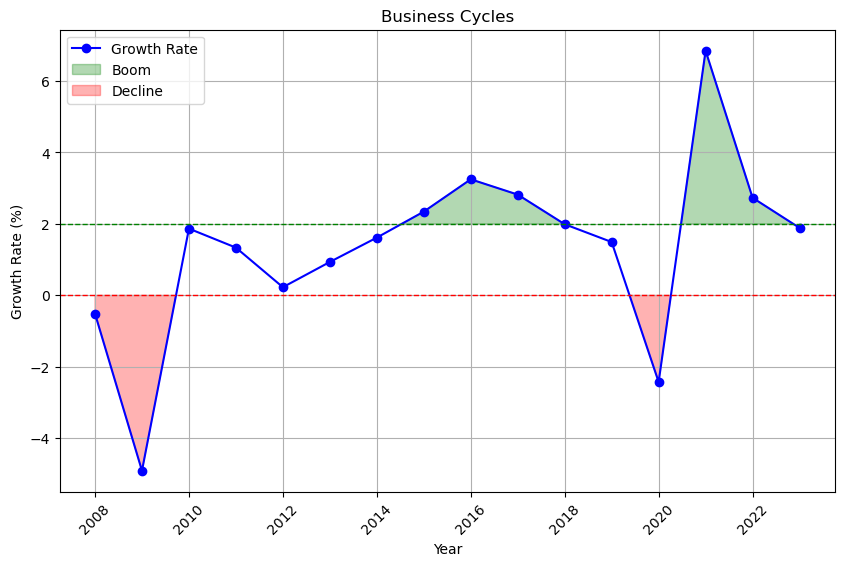

In [72]:
# Define boom and decline criteria
boom_threshold = 2
decline_threshold = 0

# Filter data starting from the year 2007
BNP_Data_filtered = BNP_Data[BNP_Data['TID'] >= 2007]

# Plot business cycles
plt.figure(figsize=(10, 6))
plt.plot(BNP_Data_filtered['TID'], BNP_Data_filtered['Growth_Rate'], color='blue', marker='o', linestyle='-')

# Highlight booms and declines
plt.fill_between(BNP_Data_filtered['TID'], boom_threshold, BNP_Data_filtered['Growth_Rate'], where=(BNP_Data_filtered['Growth_Rate'] >= boom_threshold), interpolate=True, color='green', alpha=0.3)
plt.fill_between(BNP_Data_filtered['TID'], decline_threshold, BNP_Data_filtered['Growth_Rate'], where=(BNP_Data_filtered['Growth_Rate'] <= decline_threshold), interpolate=True, color='red', alpha=0.3)

# Plot horizontal lines for thresholds
plt.axhline(y=boom_threshold, color='green', linestyle='--', linewidth=1)
plt.axhline(y=decline_threshold, color='red', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.title('Business Cycles')

# Add legend
plt.legend(['Growth Rate', 'Boom', 'Decline'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.grid(True)
plt.show()


# Merge data sets

We now want to merge our data sets so we can see if there is a correlation between unemployment rate and buisness cycles. We further want to see if these are different across age-groups. We use right-merge as dont want include 2007. Afterwards we drop GDP variable, and create a new variable which shows if the buisness cycle is in a boom, stable or decline. We now have our complete merged dataset. 


In [73]:
merged_data = pd.merge(BNP_Data, AKU_Data, on='TID', how='right')
# 'outer' method includes all rows from both datasets, 'TID' values that do not match will be filled with NaN


#Here we drop the column GDP
merged_data.drop(columns=['GDP'], inplace=True)
merged_data['TID'] = pd.to_numeric(merged_data['TID'], errors='coerce')
merged_data['Cycle_Phase'] = np.where(merged_data['Growth_Rate'] > 2, 'Boom', np.where(merged_data['Growth_Rate'] < -2, 'Decline', 'Stable'))
# Display the merged dataset
print(merged_data)

      TID  Growth_Rate        ALDER  UNR Cycle_Phase
0    2008    -0.510910  15-24 years  9.5      Stable
1    2008    -0.510910  25-34 years  3.7      Stable
2    2008    -0.510910  35-44 years  2.6      Stable
3    2008    -0.510910  45-54 years  2.0      Stable
4    2008    -0.510910  55-64 years  2.5      Stable
..    ...          ...          ...  ...         ...
107  2023     1.887955  35-44 years  4.0      Stable
108  2023     1.887955  45-54 years  2.5      Stable
109  2023     1.887955  55-64 years  3.1      Stable
110  2023     1.887955  65-74 years  2.6      Stable
111  2023     1.887955   Age, total  5.1      Stable

[112 rows x 5 columns]


# Analysis

For our analysis we want to calculate descriptive statics where we look at the unemployment-rate across age groups. We also want to look at the unemployment-rate given the buisnesscycle and if these vary across age-groups. 

In [74]:
#We first numerise the varibale UNR as it is a string
merged_data['UNR'] = pd.to_numeric(merged_data['UNR'], errors='coerce')

# Calculate the mean of UNR grouped by ALDER
mean_unemployment_by_age = merged_data.groupby('ALDER')['UNR'].mean()

# Display the mean unemployment rate by age
print(mean_unemployment_by_age)

ALDER
15-24 years    12.56250
25-34 years     7.61875
35-44 years     4.43750
45-54 years     3.85000
55-64 years     4.28750
65-74 years     2.90000
Age, total      6.01250
Name: UNR, dtype: float64


We see that there across the whole timeperiod there is a significantly larger unemployment rate for the age group 15-24 and to a large degree also 25-34. We expected this as mentioned in the introducion to the project. We now want to look at how these flucturate given the buisness cycle. We do this by grouping the mean of the unemployment rate by the type of buisness cycle for each age group.

In [75]:
# Group by both 'Business_Cycle' and 'ALDER' and calculate the mean UNR for each combination
mean_unemployment_by_phase_and_age = merged_data.groupby(['Cycle_Phase', 'ALDER'])['UNR'].mean()

# Print the mean unemployment rate for each combination of phase and age
print(mean_unemployment_by_phase_and_age)

Cycle_Phase  ALDER      
Boom         15-24 years    11.600000
             25-34 years     7.120000
             35-44 years     4.060000
             45-54 years     3.500000
             55-64 years     3.840000
             65-74 years     3.050000
             Age, total      5.540000
Decline      15-24 years    12.500000
             25-34 years     7.550000
             35-44 years     4.250000
             45-54 years     3.900000
             55-64 years     4.350000
             65-74 years          NaN
             Age, total      6.000000
Stable       15-24 years    13.111111
             25-34 years     7.911111
             35-44 years     4.688889
             45-54 years     4.033333
             55-64 years     4.522222
             65-74 years     2.600000
             Age, total      6.277778
Name: UNR, dtype: float64


We see that there is a higher unemployment rate in Declines than Boom, but it seems that they are highest in the stable periods, which indicates 1: We dont have a alot of observations 2: Our definitions of the periods aren't 100% given how we normally define buisness cycles. We now want to look at this graphicly where we have a timeline with the buisness cycles,and a drop down menue fo r each agegroup.

/Users/bertrampohti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bertrampohti/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


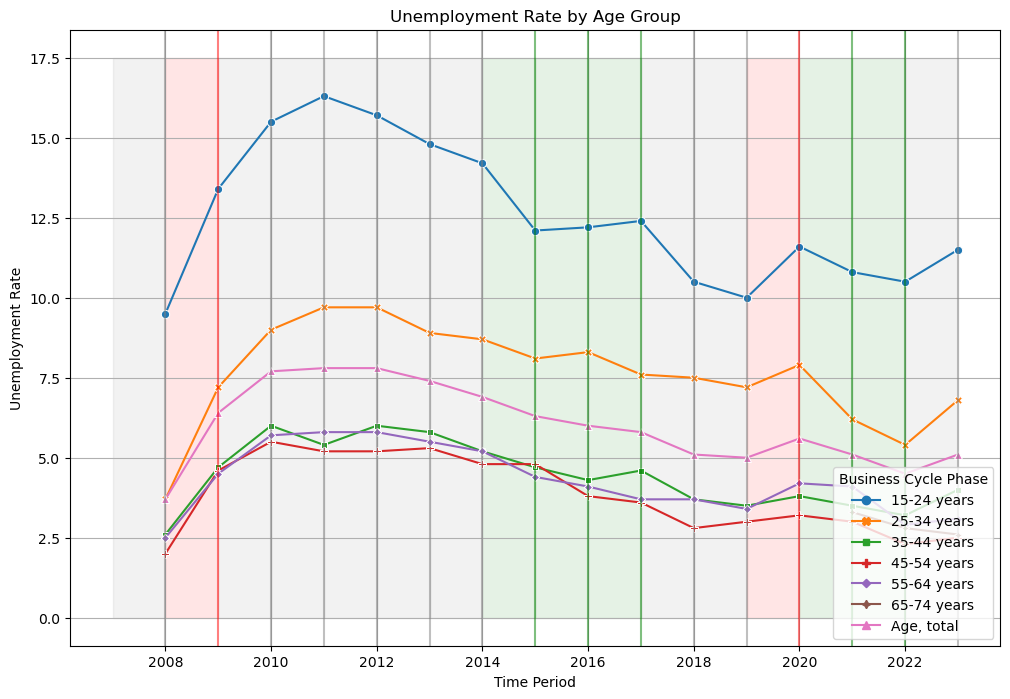

In [79]:
# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the unemployment rate for each age group
sns.lineplot(data=merged_data, x='TID', y='UNR', hue='ALDER', style='ALDER', markers=True, dashes=False, legend='full')

# Loop through each unique business cycle phase
for cycle_phase, color in {'Boom': 'green', 'Decline': 'red', 'Stable': 'grey'}.items():
    # Filter data for the current cycle phase
    cycle_data = merged_data[merged_data['Cycle_Phase'] == cycle_phase]
    
    # Plot a vertical line for each year with the color representing the cycle phase
    for tid in cycle_data['TID'].unique():
        # Get the corresponding UNR value for the current year and cycle phase
        unr_value = cycle_data[cycle_data['TID'] == tid]['UNR'].iloc[0]
        # Plot the vertical line
        plt.axvline(x=tid, ymin=0, ymax=1, color=color, linestyle='-', alpha=0.5)
        # Fill between lines for each business cycle phase
        plt.fill_betweenx(y=[0, 17.5], x1=tid - 1.0, x2=tid + 0, color=color, alpha=0.1)

# Set labels and title
plt.xlabel('Time Period')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate by Age Group')

# Show legend for both age groups and business cycle phases
plt.legend(title='Age Group')
plt.legend(title='Business Cycle Phase', loc='lower right')
plt.grid(True)
plt.show()

By inspecting the graph above we once agian see that unemployment rate is highest for the youngest age group. It also looks like it is more volitile but i can be a bit difficult to say with certainty why we also calcu late the variance in unemploument rate for each age group.

In [83]:
# Calculate variance in unemployment rate for each age group
variance_results = merged_data.groupby('ALDER')['UNR'].var()

# Convert variance results to a DataFrame for better display
variance_df = variance_results.reset_index()
variance_df.columns = ['Age Group', 'Variance in Unemployment Rate']

# Display the DataFrame
print(variance_df)

     Age Group  Variance in Unemployment Rate
0  15-24 years                       4.721167
1  25-34 years                       2.498958
2  35-44 years                       1.082500
3  45-54 years                       1.434667
4  55-64 years                       1.134500
5  65-74 years                       0.130000
6   Age, total                       1.570500


This confirms what the visual inspection showed, that the youngest group has the most volitile unemployment rate.

# Conclusion

We see that unemployment rate indeed is highest for the youngest age group as we expected. Further more we also see that the youngest age group has the by far most volitile unemployment rate, which indicates that this group has a higher share of jobs that depend on the buisness cycle. 
We found that the boom periods had the lowest rates of unemployment, but that the stable periods had a higer rate than the decline periods. This goes agianst our intuition but we do see by visiual inspection that in the decline periods unemployment rates go up. This relationship between buisness cycles and unemployment rates did not vary across age groups.
